# Task 1 : Set up colab gpu runtime environment

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

     |████████████████████████████████| 88 kB 2.6 MB/s 
     |████████████████████████████████| 58 kB 3.3 MB/s 
     |████████████████████████████████| 376 kB 30.8 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=9bc6c3bc5dea4bbb8a0f4594e87dc397c5dcbb052bfc07fef8991527732d6898
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=ae383081a6fbd00185897625803fc53ce7f251eebbf5e82a79089682095b49b3
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-2dx8pne2
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-2dx8pne2
   

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [2]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 587 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 24.48 MiB/s, done.
Resolving deltas: 100% (3/3), done.


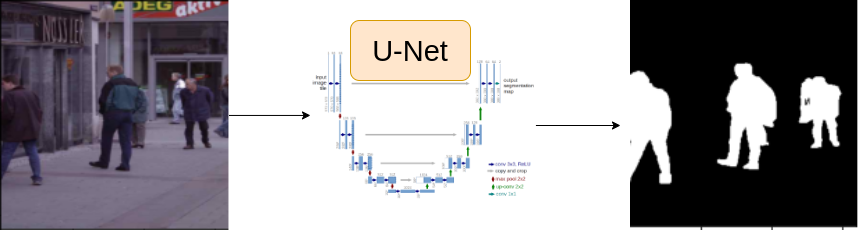

# Some Common Imports

In [3]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [4]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [41]:
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content/'
DEVICE = 'cuda'
EPOCHS = 25
LR = 0.003
IMG_SIZE = 320
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [8]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [10]:
row = df.iloc[4]
image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)/255.0


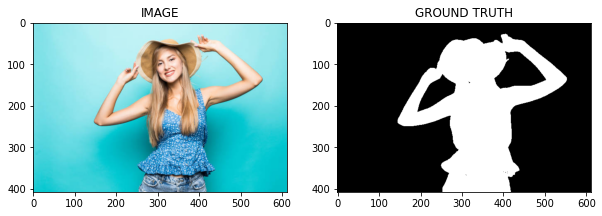

In [11]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [12]:
train_df,valid_df = train_test_split(df, test_size = 0.2, random_state = 42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [13]:
import albumentations as A

In [19]:
def get_train_augs():
  return A.Compose([
                    A.Resize(IMG_SIZE, IMG_SIZE),
                    A.HorizontalFlip(p = 0.5),
                    A.VerticalFlip(p = 0.5)
  ])

def get_valid_augs():
  return A.Compose([
                    A.Resize(IMG_SIZE, IMG_SIZE),
                    
  ])

# Task 4 : Create Custom Dataset 

In [15]:
from torch.utils.data import Dataset

In [26]:
class SegmentationDataset(Dataset):
  def __init__(self, df,augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self,idx):
    row = self.df.iloc[idx]

    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = np.expand_dims(mask, axis = -1)

    if self.augmentations:
      data = self.augmentations(image = image, mask = mask)
      image = data['image']
      mask = data['mask']

    image = np.transpose(image,(2,0,1)).astype(np.float32)
    mask = np.transpose(mask,(2,0,1)).astype(np.float32)

    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask)/255.0)

    return image, mask

In [28]:
trainset = SegmentationDataset(train_df,get_train_augs())
validset = SegmentationDataset(valid_df,get_valid_augs())

In [22]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


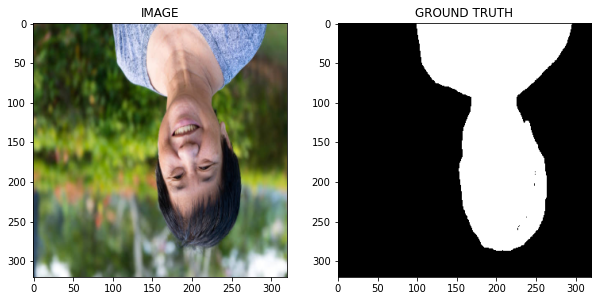

In [29]:
idx = 3

image, mask = trainset[idx]
helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [30]:
from torch.utils.data import DataLoader

In [34]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [35]:
print(f'total no. of batches in trainloader : {len(trainloader)}')
print(f'total no. of batches in validloader : {len(validloader)}')

total no. of batches in trainloader : 15
total no. of batches in validloader : 4


In [36]:
for image, mask in trainloader:
  break
print(f"One batch image shape : {image.shape}")
print(f"One batch mask shape : {mask.shape}")

One batch image shape : torch.Size([16, 3, 320, 320])
One batch mask shape : torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [37]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [39]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3,
        classes = 1,
        activation = None

    )
  
  def forward(self, images, masks = None):

    logits = self.arc(images)

    if masks != None:
      loss1 = DiceLoss(mode = 'binary')(logits,masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1+loss2

    return logits

In [44]:
model = SegmentationModel()
model.to(DEVICE)

SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): Swish()
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act1): Swish()
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
            (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn2): BatchNorm2d(16, eps

# Task 7 : Create Train and Validation Function 

In [45]:
def  train_fn(data_loader, model, optimizer):
  model.train()
  total_loss = 0.0

  for images, masks in tqdm(data_loader):
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits,loss = model(images,masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss/len(data_loader)


In [49]:
def  eval_fn(data_loader, model):
  model.eval()
  total_loss = 0.0
  with torch.no_grad():
    for images, masks in tqdm(data_loader):
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

    
      logits,loss = model(images,masks)


      total_loss += loss.item()

    return total_loss/len(data_loader)

# Task 8 : Train Model

In [47]:
optimizer = torch.optim.Adam(model.parameters(),lr = LR)

In [50]:
best_valid_loss = np.Inf
for i in range(EPOCHS):
  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(),'best_model.pt')
    print("SAVED-MODEL")
    best_valid_loss = valid_loss
  print(f"Epoch : {i+1} Train_loss : {train_loss} Valid_loss : {valid_loss}")

100%|██████████| 4/4 [00:01<00:00,  2.04it/s]


SAVED-MODEL
Epoch : 1 Train_loss : 0.3675261914730072 Valid_loss : 0.5118375197052956


100%|██████████| 4/4 [00:01<00:00,  2.72it/s]


SAVED-MODEL
Epoch : 2 Train_loss : 0.29526593585809074 Valid_loss : 0.270651925355196


100%|██████████| 4/4 [00:01<00:00,  2.81it/s]


Epoch : 3 Train_loss : 0.25318618516127267 Valid_loss : 0.31149235367774963


100%|██████████| 4/4 [00:01<00:00,  2.81it/s]


SAVED-MODEL
Epoch : 4 Train_loss : 0.2468512068192164 Valid_loss : 0.23551400750875473


100%|██████████| 4/4 [00:01<00:00,  2.79it/s]


Epoch : 5 Train_loss : 0.2179028034210205 Valid_loss : 0.29237502068281174


100%|██████████| 4/4 [00:01<00:00,  2.80it/s]


SAVED-MODEL
Epoch : 6 Train_loss : 0.22460049788157146 Valid_loss : 0.20926668867468834


100%|██████████| 4/4 [00:01<00:00,  2.22it/s]


SAVED-MODEL
Epoch : 7 Train_loss : 0.19133001069227853 Valid_loss : 0.17549392208456993


100%|██████████| 4/4 [00:01<00:00,  2.36it/s]


Epoch : 8 Train_loss : 0.152376888692379 Valid_loss : 0.1796063631772995


100%|██████████| 4/4 [00:01<00:00,  2.59it/s]


Epoch : 9 Train_loss : 0.13697541058063506 Valid_loss : 0.19830549880862236


100%|██████████| 4/4 [00:01<00:00,  2.32it/s]


SAVED-MODEL
Epoch : 10 Train_loss : 0.1546635965506236 Valid_loss : 0.17254409939050674


100%|██████████| 4/4 [00:01<00:00,  2.62it/s]


Epoch : 11 Train_loss : 0.14478633552789688 Valid_loss : 0.2544265426695347


100%|██████████| 4/4 [00:01<00:00,  2.40it/s]


Epoch : 12 Train_loss : 0.1967790335416794 Valid_loss : 0.2081378512084484


100%|██████████| 4/4 [00:01<00:00,  2.09it/s]


Epoch : 13 Train_loss : 0.15815482437610626 Valid_loss : 0.18703177198767662


100%|██████████| 4/4 [00:01<00:00,  2.26it/s]


Epoch : 14 Train_loss : 0.16957968225081763 Valid_loss : 0.21571462601423264


100%|██████████| 4/4 [00:01<00:00,  2.20it/s]


Epoch : 15 Train_loss : 0.16008405685424804 Valid_loss : 0.21348293498158455


100%|██████████| 4/4 [00:01<00:00,  2.09it/s]


Epoch : 16 Train_loss : 0.1457526961962382 Valid_loss : 0.2125350572168827


100%|██████████| 4/4 [00:01<00:00,  2.12it/s]


Epoch : 17 Train_loss : 0.15299490392208098 Valid_loss : 0.2917467728257179


100%|██████████| 4/4 [00:01<00:00,  2.62it/s]


Epoch : 18 Train_loss : 0.21816513140996296 Valid_loss : 0.20596133172512054


100%|██████████| 4/4 [00:01<00:00,  2.24it/s]


Epoch : 19 Train_loss : 0.14899273812770844 Valid_loss : 0.22330182790756226


100%|██████████| 4/4 [00:01<00:00,  2.40it/s]


Epoch : 20 Train_loss : 0.15958693474531174 Valid_loss : 0.24078034237027168


100%|██████████| 4/4 [00:01<00:00,  2.14it/s]


Epoch : 21 Train_loss : 0.14290773918231328 Valid_loss : 0.19814178720116615


100%|██████████| 4/4 [00:01<00:00,  2.37it/s]


Epoch : 22 Train_loss : 0.12483269075552622 Valid_loss : 0.19602660089731216


100%|██████████| 4/4 [00:01<00:00,  2.21it/s]


Epoch : 23 Train_loss : 0.11271289388338725 Valid_loss : 0.2550867944955826


100%|██████████| 4/4 [00:01<00:00,  2.37it/s]


Epoch : 24 Train_loss : 0.12407380292812983 Valid_loss : 0.23493840731680393


100%|██████████| 4/4 [00:01<00:00,  2.18it/s]

Epoch : 25 Train_loss : 0.12087179968754451 Valid_loss : 0.1987425461411476


# Task 9 : Inference

In [51]:
idx = 2
model.load_state_dict(torch.load('/content/best_model.pt'))
image, mask = validset[idx]
logits_mask = model(image.to(DEVICE).unsqueeze(0))
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5)*1.0

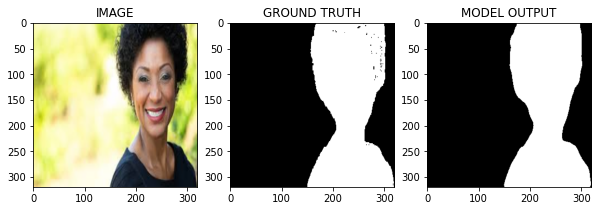

In [52]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))